In [ ]:
!pip install keras_utils
!pip install keras==2.2.4

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, concatenate, Flatten
from tensorflow.keras import Input, Model
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Flatten, Lambda
from tensorflow.keras.models import Model
import cv2
import csv
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import os
import random
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from IPython.display import Image, display
# import for relu6
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_16 (Functional)           (None, 1)            2268185     input_31[0][0]                   
                                                                 input_32[0][0]                   
__________________________________________________________________________________________________
subtract_6 (Subtract)           (None, 1)            0           model_16[0][0]            

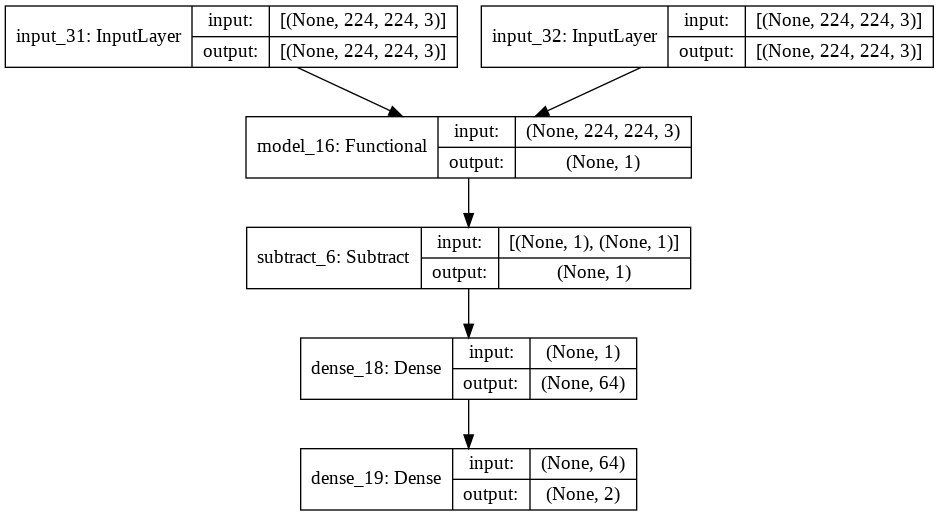

In [ ]:
def relu6(x):
    return K.relu(x, max_value=6)
model_name = 'MobileNetV2.h5'
with CustomObjectScope({'relu6': relu6}):
# Recreate the exact same model, including its weights and the optimizer
  siamese_model = load_model('/content/drive/MyDrive/Daming Colab/Ranking_siamese network/MobileNet_SiameseModel.h5')
# Show the model architecture
siamese_model.summary()

plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#### Path TO Image     
#### For single pair test
#### input image path directly

def preparePredict(path):             
    Image=cv2.imread(path)
    #Image=cv2.resize(Image,(224,224))
    Image=np.expand_dims(Image,axis=0)   

    return Image
    
def Predict(img1,img2):

    #x=np.concatenate((Test1,Test2),axis=0)
    score=siamese_model.predict([img1,img2])
    score=np.squeeze(score)
    
    ResultDict=['the 1st frame is better','the 2nd frame is better']
    result=ResultDict[np.argmin(score)]
    
    return score,result

In [ ]:
####                                 TEST                                                   ####
####    id1 > id2          score of 0 < score of 1      label=1    1st is a better frame    ####
####    id1 < id2          score of 0 > score of 1      label=0    2nd is a better frame    ####

In [ ]:
Frames_Path='/content/drive/MyDrive/Daming Colab/Ranking_siamese network/Frames'

for files in  os.listdir(Frames_Path):     
    Frames= os.listdir(Frames_Path)
    
Frames_num=np.size(Frames)
print('Frames_num == ',Frames_num)

def RandomPredict():
  index=random.sample(range(1,Frames_num),2)

  Frame_1=Frames[index[0]]
  Frame_2=Frames[index[1]]
  Frame_1=preparePredict(Frames_Path+'/'+Frame_1)
  Frame_2=preparePredict(Frames_Path+'/'+Frame_2)

  score,answer=Predict(Frame_1,Frame_2)
  
  temp=[index[0],index[1]]


  return temp,score,answer

Frames_num ==  432


In [ ]:
temp,score,answer=RandomPredict()
score_sum=score[0]+score[1]
print('temp info: ',temp,'   results are: ',score,answer)
#print(score_sum)

temp info:  [353, 72]    results are:  [3.7867127e-13 1.0000000e+00] the 1st frame is better


In [ ]:
rank = np.zeros((Frames_num,2))
print(rank.shape)

for i in tqdm(range(5000)):
  temp,score,answer=RandomPredict()
  rank[temp[0],0]=temp[0]
  rank[temp[0],1]+=(1-score[0])

  rank[temp[1],0]=temp[1]
  rank[temp[1],1]+=(1-score[1])

print(rank)

In [ ]:
scorelist=rank[:,1]
idlist=rank[:,0]

max_score=max(scorelist)
min_score=min(scorelist)
max_id=np.argmax(scorelist)
min_id=np.argmin(scorelist)

print('maxscore',max_score,'maxid',max_id)
print('minscore',min_score,'minid',min_id)

deltascore=max_score-min_score
scaleindex=100/deltascore

for i in range(Frames_num):
    scorelist[i]=(scorelist[i]-min_score)*scaleindex

maxscore 31.408811010758072 maxid 431
minscore 0.0 minid 0


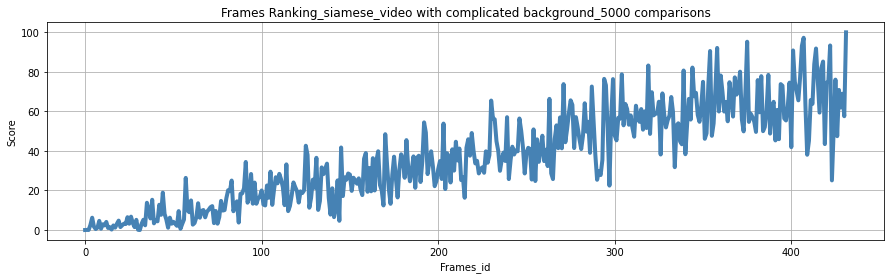

In [ ]:
fig=plt.figure(figsize=(15,4))

plt.plot(idlist,scorelist,color='steelblue',lw=4)
plt.grid()
plt.title("Frames Ranking_siamese_video with complicated background_5000 comparisons")
plt.xlabel('Frames_id')
plt.ylabel('Score')

plt.show()

In [ ]:
np.savetxt("ranking_result（with disappear）.txt", rank)

bestframe_score=np.max(rank[:,1])
bestframe_index = int(np.argmax(rank[:,1]))

print('max score is: ',bestframe_score,'\n','best frame is: frame',bestframe_index)


max score is:  214.74853428037034 
 best frame is: frame 154


In [ ]:
bestframe_path = os.path.join(Frames_Path,'frame'+str(bestframe_index)+'.jpg')
print(bestframe_path)

bestframe=cv2.imread(bestframe_path)
cv2.imwrite('best_frame（with disappear）.png',bestframe)
display(Image('/content/drive/MyDrive/Colab Notebooks/Ranking_siamese network/best_frame（with  disappear）.png'))

/content/drive/MyDrive/Colab Notebooks/Ranking_siamese network/Frames_disappear/frame154.jpg
